<a href="https://colab.research.google.com/github/saritmaitra/Prospect-Response-Propensity-Model/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

In [3]:
from google.colab import files
uploaded = files.upload()

Saving propensity data.csv to propensity data.csv


In [55]:
df = pd.read_csv('propensity data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
35896,37,housemaid,single,university.degree,no,no,no,cellular,may,fri,288,2,999,0,nonexistent,-1.8,92.893,-46.2,1.259,5099.1,yes
13131,31,services,married,basic.9y,no,yes,no,cellular,jul,wed,537,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,yes
2563,36,blue-collar,divorced,high.school,no,no,no,telephone,may,tue,531,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
15144,32,admin.,single,university.degree,no,no,no,cellular,jul,thu,79,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
2254,29,management,married,university.degree,no,no,no,telephone,may,tue,134,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


In [5]:
df.shape

(41188, 21)

### Variables with unknown values are : 
- 'education', 'job', 'housing', 'loan', 'deafult', and 'marital'. 
- 'education (1731)', 'job (330)', 'housing (990)', and 'loan (990)'' are significant. 
- unknown for 'marital (80)' is very low. 
- The unknown for 'default' variable are considered to be recorded as unknown. It may be possible that customer is not willing to disclose this information to the banking representative. Hence the unknown value in 'default' is actually a separate value.

We start with creating new variables for the unknown values in 'education', 'job', 'housing' and 'loan'. We do this to see if the values are missing at random or is there a pattern in the missing values.

In [0]:
sig_cat_var = ['education','job','housing','loan']
for var in sig_cat_var:
    df[var + '_un'] = (df[var] == 'unknown').astype(int)

### Imputation:
Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person. Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

In [0]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [8]:
cross_tab(df,'job','education')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,597,276,75,145,241,98,285,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


In [9]:
df['job'][df['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

In [0]:
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'university.degree'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'high.school'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.4y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.6y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.9y'), 'job'] = 'blue-collar'
df.loc[(df['job']=='unknown') & (df['education']=='professional.course'), 'job'] = 'technician'

In [11]:
cross_tab(df,'job','education')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77.0,3329,151.0,499.0,363.0,249.0,5753,1.0
blue-collar,2366.0,878,1448.0,3654.0,453.0,454.0,94,8.0
entrepreneur,137.0,234,71.0,210.0,135.0,57.0,610,2.0
housemaid,516.0,174,77.0,94.0,59.0,0.0,139,1.0
management,100.0,298,85.0,166.0,89.0,0.0,2186,0.0
retired,601.0,276,75.0,145.0,243.0,112.0,286,3.0
self-employed,93.0,118,25.0,220.0,168.0,29.0,765,3.0
services,132.0,2832,226.0,388.0,218.0,0.0,173,0.0
student,26.0,357,13.0,99.0,43.0,167.0,170,0.0
technician,58.0,873,87.0,384.0,3330.0,212.0,1809,0.0


### we are able to reduce the number of unknowns and enhance our data set.

In [0]:
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

### Imputations for house and loan : 
We are again using cross-tabulation between 'house' and 'job' and between 'loan' and 'job.' Our hypothesis is that housing loan status (Yes or No) should be in the proportion of each job category. Hence using the prior known distribution of the housing loan for each job category, the house loan for unknown people will be predicted such that the prior distribution (% House = Yes's and No's for each job category remains the same). Similarly, we have filled the missing values in the 'loan' variable.

In [0]:
def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

In [0]:
def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df

In [56]:
df=fillhousing(df,jobhousing)
df=fillloan(df,jobloan)
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1879,30,housemaid,married,high.school,unknown,yes,no,telephone,may,fri,175,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
8952,34,technician,single,professional.course,no,no,no,telephone,jun,thu,432,8,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,no
28657,52,blue-collar,divorced,basic.4y,no,yes,no,cellular,apr,thu,291,1,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,no
30058,44,admin.,married,university.degree,no,no,no,cellular,apr,thu,172,1,999,0,nonexistent,-1.8,93.075,-47.1,1.406,5099.1,yes
30665,36,admin.,divorced,high.school,no,yes,no,telephone,may,tue,19,2,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,no


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 25 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
education_un      41188 non-null int64
job_un      


## Numerical variables:
Let see the summary of the data in order to understand the numerical variables.

In [17]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
education_un        int64
job_un              int64
housing_un          int64
loan_un             int64
dtype: object

In [18]:
num_var = ['age','campaign', 'duration', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m',
                      'nr.employed']
df[num_var].describe()

,age,campaign,duration,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,258.285010,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,259.279249,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,102.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,180.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,319.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,4918.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Missing Values: 
From the source of the data the missing values, or NaNs, are encoded as '999'. From the above table, it is clear that only 'pdays' has missing values. Moreover, a majority of the values for 'pdays' are missing.

### Age:
   * Average age of the people in the dataset is ~40 with std of 10.42
   * Min. age is 17
   * Max. age is 98
   * quantile refers that 75% of the people have 47or less  age.
   * As 98 is max, this is likely as outlier ["47*(3/2) = 70.5 ". So anything greater than 70.5 is outlier].

### Duration:
   * Average duration of the people speaking in the dataset is (approx)258 with std of 259, as standard deviation is quite huge it means that duration is wide spread across the dataset.
   * Min. duration is 0
   * Max. duration is 4918
   * quantile 75%(percentile) refers that 75 percentage of the people spoke for 319 seconds or less.
   * while comparing with 75% quantile, 4981 is a outlier data point.

### Outliers: 
It can be seen that only 'age', 'campaign', duration have outliers.

But we also see that the value of these outliers are not so unrealistic (max('age')=98 and max('campaign')=56). Hence, we need not remove them since the prediction model should represent the real world. This improves the generalizability of the model and makes it robust for real world situations. The outliers, therefore, are not removed.
## Missing Values in Numerical Variables
Let's examine the missing values in 'pdays'

We have seen from pairplot that data here is not-symmetric. Let's examine the missing values in 'pdays'

In [19]:
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)

poutcome,failure,nonexistent,success
pdays,,,
0,0.000000,0.000000,0.000364
1,0.000000,0.000000,0.000631
2,0.000000,0.000000,0.001481
3,0.000097,0.000000,0.010561
4,0.000049,0.000000,0.002816
5,0.000097,0.000000,0.001020
6,0.000607,0.000000,0.009396
7,0.000364,0.000000,0.001093
8,0.000146,0.000000,0.000291


As we can see from the above table, the majority of the values for 'pdays' are missing especially in  the 'non-existent' category. This means that the majority of the values in 'pdays' are missing because the customer was never contacted before. 

To deal with this variable, we removed the numerical variable 'pdays' and replaced it with categorical variables with following categories: p_miss, p_less_5, p_bet_5_15, and p_great_15.

Since we have many categorical variables, dummy variables needs to be created for those vaiables.

In [20]:
#Add new categorical variables to our dataframe.
df['p_miss'] = 0
df['p_less_5'] = 0
df['p_great_15'] = 0
df['p_bet_5_15'] = 0
df['p_miss'][df['pdays']==999] = 1
df['p_less_5'][df['pdays']<5] = 1
df['p_great_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['p_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
drop = df.drop('pdays', axis=1)

dummies=pd.get_dummies(drop)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [21]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 72 columns):
age                              41188 non-null int64
duration                         41188 non-null int64
campaign                         41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
education_un                     41188 non-null int64
job_un                           41188 non-null int64
housing_un                       41188 non-null int64
loan_un                          41188 non-null int64
p_miss                           41188 non-null int64
p_less_5                         41188 non-null int64
p_great_15                       41188 non-null int64
p_bet_5_15       

For any matrix-based regression , Singular Matrices always throw an error in Python . Therefore, had to throw one of the columns away while creating dummy variables. We will still be able to infer the missing category from the remaining variables.

In [57]:
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df
features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular',
                    'education_unknown','job_unknown','housing_unknown','loan_unknown', 'p_less_5']
df1 = dropfeature(dummies, features_dropped)
df1.sample(5)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,education_un,job_un,housing_un,loan_un,p_miss,p_great_15,p_bet_5_15,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_unknown,default_yes,housing_yes,loan_yes,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
30553,31,220,4,0,-1.8,92.893,-46.2,1.354,5099.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
7925,41,312,1,0,1.4,94.465,-41.8,4.865,5228.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
14582,26,878,2,0,1.4,93.918,-42.7,4.961,5228.1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
17721,41,99,6,0,1.4,93.918,-42.7,4.961,5228.1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
16322,36,864,4,0,1.4,93.918,-42.7,4.961,5228.1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 61 columns):
age                              41188 non-null int64
duration                         41188 non-null int64
campaign                         41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
education_un                     41188 non-null int64
job_un                           41188 non-null int64
housing_un                       41188 non-null int64
loan_un                          41188 non-null int64
p_miss                           41188 non-null int64
p_great_15                       41188 non-null int64
p_bet_5_15                       41188 non-null int64
job_admin.       

## Model Building and Evaluation
In general, algorithms that exploit distances or similarities (e.g. in form of scalar product) between data samples, such as k-NN and SVM, are sensitive to feature transformations. Though graphical-model based classifiers, such as Fisher LDA or Naive Bayes, Decision trees and Tree-based ensemble methods (RF, XGB) are invariant to feature scaling, but still it might be a good idea to rescale/standartise the data.


In [0]:
# Using the data frame where we had created dummy variables
y = df1['y_yes'].values
X = df1.drop(columns = ['y_yes'])

In [25]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 60 columns):
age                              41188 non-null int64
duration                         41188 non-null int64
campaign                         41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
education_un                     41188 non-null int64
job_un                           41188 non-null int64
housing_un                       41188 non-null int64
loan_un                          41188 non-null int64
p_miss                           41188 non-null int64
p_great_15                       41188 non-null int64
p_bet_5_15                       41188 non-null int64
job_admin.       

In [26]:
y

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [27]:
# Rescale data (between 0 and 1)
import pandas
import scipy
import numpy
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
# summarise transformed data
numpy.set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[0.481 0.053 0.    0.    0.938 0.699 0.603 0.957 0.86  0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    0.    1.    0.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.   ]
 [0.494 0.03  0.    0.    0.938 0.699 0.603 0.957 0.86  0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.   ]
 [0.247 0.046 0.    0.    0.938 0.699 0.603 0.957 0.86  0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.    1.    0.    1.    0.    0.    0.    0.    0.    0

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# split data into train and test sets
seed = 123
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


A number of ML algorithm can be ussed for model developement. I will do an algorithm comparison to check which classifier prduces best score on training data.
### Avoiding Overfitting
An error in the modeling algorithm that takes into consideration random noise in the fitting process rather than the pattern itself. This occurs when the model gets an excellent score in the training set but poor score on test data. This is likely to happen because of overfitting of the data (taking into consideration random noise in the pattern). The model should take the overall pattern of the data in order to correctly classify whether a potential client will suscribe to a term deposit or not. To avoid overfitting I have used cross validation. This algorithm will iterate through all the training and test sets and the main purpose of this is to grab the overall pattern of the data.

 LR : 0.910165 (0.003969)
 GBC : 0.916543 (0.002792)
 KNN : 0.902084 (0.003413)
 RF : 0.911977 (0.003775)
 XGB : 0.916833 (0.004097)


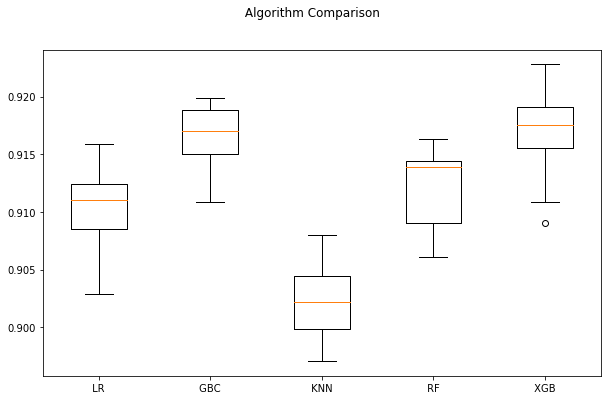

In [29]:
import time

from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# prepare models
models = []
models.append(( ' LR ' , LogisticRegression(solver='lbfgs', max_iter=5000)))
models.append(( ' GBC ' , GradientBoostingClassifier()))
models.append(( ' KNN ' , KNeighborsClassifier()))
models.append(( ' RF ' , RandomForestClassifier(n_estimators=60)))
models.append(( ' XGB ' , XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Simple Ensemble technique
### Max Voting

In [0]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression(solver='lbfgs', max_iter=5000)
model2 = GradientBoostingClassifier()
model3 = KNeighborsClassifier()
model4 = RandomForestClassifier(n_estimators=60)
model5 = XGBClassifier()
model = VotingClassifier(estimators=[('LR', model1), ('GBC', model2), ('kNN', model3), 
                                    ('RF', model4), ('XGB', model5)], voting='hard')




In [31]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9153240638563966

In [69]:
# make predictions for test set
y_pred = model5.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.50%


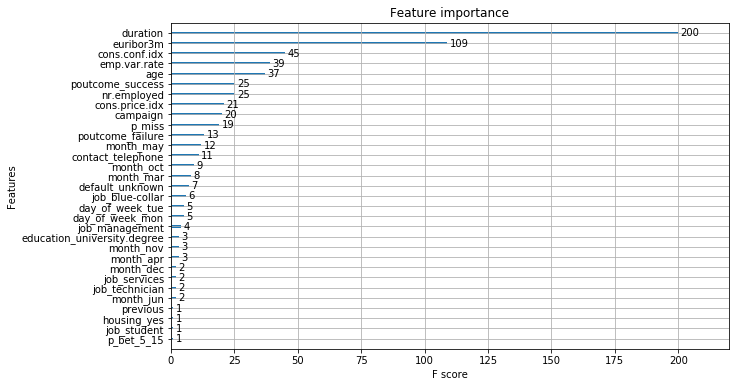

In [72]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plot_importance(model5)
pyplot.show()

In [75]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model5.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model5, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
Thresh=0.000, n=60, Accuracy: 91.50%
T

## Bagging

In [87]:
from sklearn.ensemble import AdaBoostClassifier
RANDOM_SEED = 123

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=60)
lr_clf = LogisticRegression(solver='lbfgs', max_iter=5000)
knn_clf = KNeighborsClassifier()
gbc_clf = GradientBoostingClassifier() 
xgb_clf = XGBClassifier()
adab_clf = AdaBoostClassifier()

classifier_array = [rf_clf, lr_clf, knn_clf, gbc_clf, xgb_clf, adab_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]

normal_accuracy = []
normal_std = []

bagging_accuracy = []
bagging_std = []

for clf in classifier_array:
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, max_features=60, random_state=RANDOM_SEED)
    bagging_scores = cross_val_score(bagging_clf, X_train, y_train, cv=10, n_jobs=-1)
    
    normal_accuracy.append(np.round(cv_scores.mean(),4))
    normal_std.append(np.round(cv_scores.std(),4))
    
    bagging_accuracy.append(np.round(bagging_scores.mean(),4))
    bagging_std.append(np.round(bagging_scores.std(),4))
    
    print("Accuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))
    print("Accuracy: %0.4f (+/- %0.4f) [Bagging %s]\n" % (bagging_scores.mean(), bagging_scores.std(), clf.__class__.__name__))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 0.9129 (+/- 0.0044) [Normal RandomForestClassifier]
Accuracy: 0.9135 (+/- 0.0040) [Bagging RandomForestClassifier]

Accuracy: 0.9103 (+/- 0.0023) [Normal LogisticRegression]
Accuracy: 0.9106 (+/- 0.0019) [Bagging LogisticRegression]



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 0.9021 (+/- 0.0039) [Normal KNeighborsClassifier]
Accuracy: 0.9020 (+/- 0.0046) [Bagging KNeighborsClassifier]

Accuracy: 0.9171 (+/- 0.0023) [Normal GradientBoostingClassifier]
Accuracy: 0.9172 (+/- 0.0034) [Bagging GradientBoostingClassifier]



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 0.9172 (+/- 0.0037) [Normal XGBClassifier]
Accuracy: 0.9170 (+/- 0.0034) [Bagging XGBClassifier]

Accuracy: 0.9100 (+/- 0.0038) [Normal AdaBoostClassifier]
Accuracy: 0.9106 (+/- 0.0037) [Bagging AdaBoostClassifier]



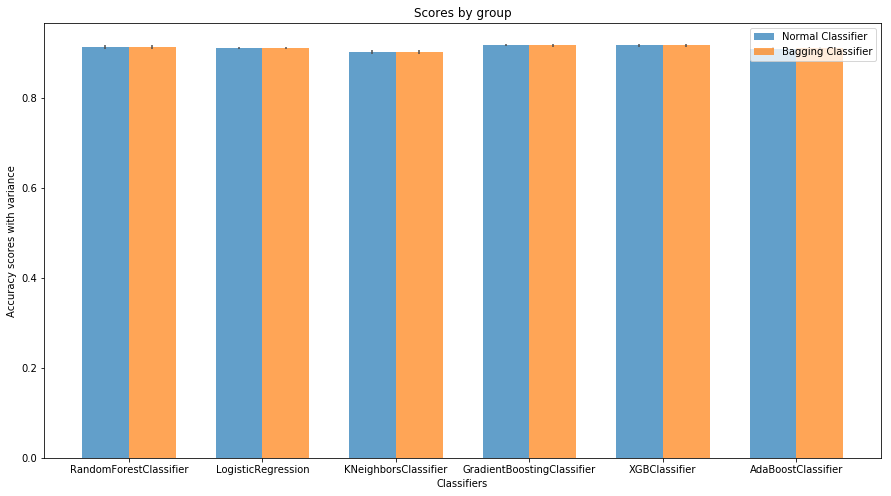

In [92]:
### Bagging plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(15,8))
n_groups = 6
index = np.arange(n_groups)
bar_width = 0.35
opacity = .7
error_config = {'ecolor': '0.3'}

normal_clf = ax.bar(index, normal_accuracy, bar_width, alpha=opacity, yerr=normal_std, error_kw=error_config, label='Normal Classifier')
bagging_clf = ax.bar(index + bar_width, bagging_accuracy, bar_width, alpha=opacity, yerr=bagging_std, error_kw=error_config, label='Bagging Classifier')
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores with variance')
ax.set_title('Scores by group')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

## Stacking

In [99]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

stack_clf = StackingClassifier(classifiers=[rf_clf, lr_clf, knn_clf, gbc_clf, adab_clf], meta_classifier=xgb_clf)
classifier_array = [rf_clf, lr_clf, knn_clf, gbc_clf, adab_clf, stack_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]
acc_list = []
var_list = []
for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))
    acc_list.append(np.round(cv_scores.mean(),4))
    var_list.append(np.round(cv_scores.std(),4))

Accuracy: 0.9123 (+/- 0.0030) [RandomForestClassifier]
Accuracy: 0.9103 (+/- 0.0023) [LogisticRegression]
Accuracy: 0.9021 (+/- 0.0039) [KNeighborsClassifier]
Accuracy: 0.9171 (+/- 0.0024) [GradientBoostingClassifier]
Accuracy: 0.9100 (+/- 0.0038) [AdaBoostClassifier]
Accuracy: 0.9125 (+/- 0.0030) [StackingClassifier]


### Stacking using probability score
Instead of using the actual class label of the base learners, here used the probability scores of each of the base models to train the meta-classifier (xgb). 

In [100]:
stack_clf = StackingClassifier(classifiers=[rf_clf, lr_clf, knn_clf, gbc_clf, adab_clf], 
                               use_probas=True, average_probas=False, meta_classifier=xgb_clf)

classifier_array = [rf_clf, lr_clf, knn_clf, gbc_clf, adab_clf, stack_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]
for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))

Accuracy: 0.9116 (+/- 0.0040) [RandomForestClassifier]
Accuracy: 0.9103 (+/- 0.0023) [LogisticRegression]
Accuracy: 0.9021 (+/- 0.0039) [KNeighborsClassifier]
Accuracy: 0.9171 (+/- 0.0024) [GradientBoostingClassifier]
Accuracy: 0.9100 (+/- 0.0038) [AdaBoostClassifier]
Accuracy: 0.9121 (+/- 0.0028) [StackingClassifier]


### Accuracy score could not be imporved inspite of heavy duty grid search and boosting through ensemble techniques. This is one limitation of gradient boosting machine learning algorithm.